[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e0e5796c7950747382a13abb27677223de5211113c946627a3b1dca0ac5eb47d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [3]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [4]:
import os

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['tulip', 'dandelion', 'daisy', 'rose', 'sunflower']

In [5]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: tulip. Imágenes: 984
Categoría: dandelion. Imágenes: 1055
Categoría: daisy. Imágenes: 769
Categoría: rose. Imágenes: 784
Categoría: sunflower. Imágenes: 734


In [6]:
imgs[:5]
len(imgs)

4323

Podemos visualizar algunas imágenes en el dataset.

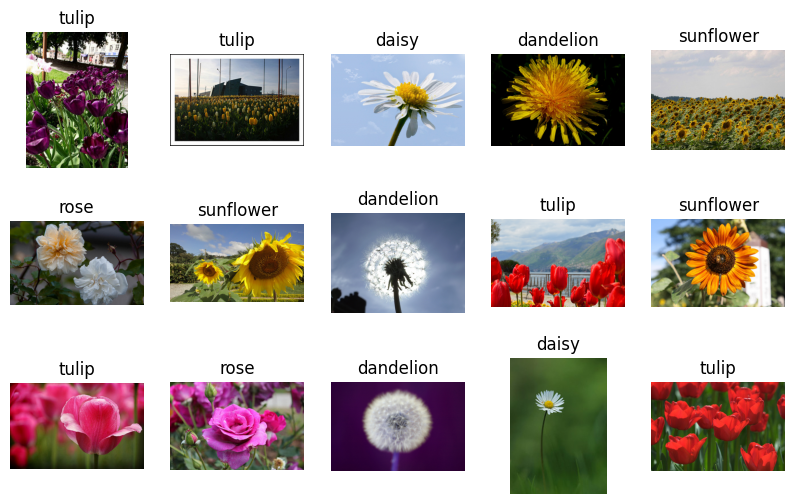

In [7]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [8]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [9]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [10]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

In [11]:
dataset['train'][2]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0667, 0.0667],
          [0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0627, 0.0627],
          [0.0000, 0.0000, 0.0000,  ..., 0.0627, 0.0627, 0.0588],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0431, 0.0471],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0471, 0.0431],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0471, 0.0392],
          ...,
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0627, 0.0667],
          [0.0588, 0.0627, 0.0588,  ..., 0.0745, 0.0627, 0.0667],
          [0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0627, 0.0667]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0392, 0.0353],
          [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0392, 0.0314],
          [0.0000, 0.0000, 0.0000,  ...,

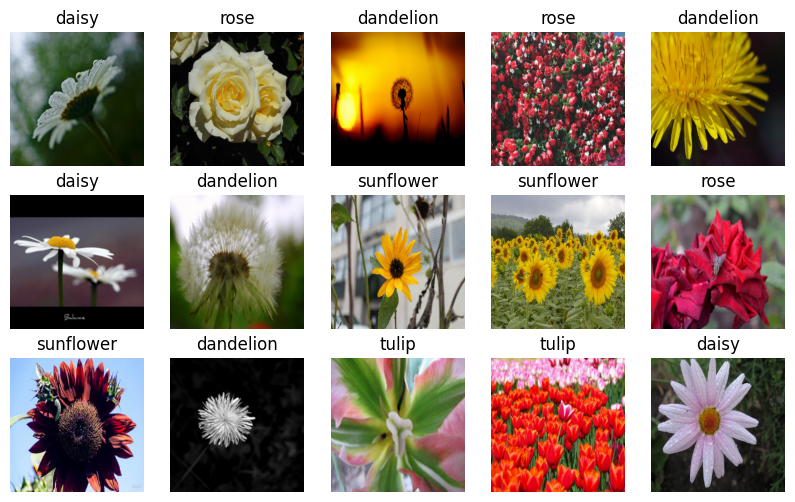

In [12]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [14]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [16]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [17]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [18]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 2.19200 val_acc 0.23381: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 1/15 loss 1.34611 val_loss 2.19200 acc 0.43920 val_acc 0.23381


val_loss 2.38411 val_acc 0.28033: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 2/15 loss 1.14746 val_loss 2.38411 acc 0.53551 val_acc 0.28033


val_loss 5.54060 val_acc 0.21018: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 3/15 loss 1.03349 val_loss 5.54060 acc 0.58040 val_acc 0.21018


val_loss 7.03701 val_acc 0.22201: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 4/15 loss 0.95865 val_loss 7.03701 acc 0.61477 val_acc 0.22201


val_loss 4.06798 val_acc 0.17296: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 5/15 loss 0.93297 val_loss 4.06798 acc 0.63807 val_acc 0.17296


val_loss 1.39443 val_acc 0.47145: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Epoch 6/15 loss 0.86499 val_loss 1.39443 acc 0.66250 val_acc 0.47145


val_loss 2.22822 val_acc 0.43743: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Epoch 7/15 loss 0.79526 val_loss 2.22822 acc 0.69915 val_acc 0.43743


val_loss 1.82992 val_acc 0.50110: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Epoch 8/15 loss 0.77092 val_loss 1.82992 acc 0.70739 val_acc 0.50110


val_loss 17.87924 val_acc 0.21092: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 9/15 loss 0.70605 val_loss 17.87924 acc 0.73324 val_acc 0.21092


val_loss 10.29122 val_acc 0.23604: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 10/15 loss 0.72185 val_loss 10.29122 acc 0.73068 val_acc 0.23604


val_loss 30.95224 val_acc 0.16320: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 11/15 loss 0.67854 val_loss 30.95224 acc 0.74886 val_acc 0.16320


val_loss 1.14235 val_acc 0.61433: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 12/15 loss 0.69761 val_loss 1.14235 acc 0.73807 val_acc 0.61433


val_loss 4.14548 val_acc 0.36142: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch 13/15 loss 0.62083 val_loss 4.14548 acc 0.76761 val_acc 0.36142


val_loss 37.87866 val_acc 0.22698: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Epoch 14/15 loss 0.59396 val_loss 37.87866 acc 0.78125 val_acc 0.22698


val_loss 15.55106 val_acc 0.23701: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

Epoch 15/15 loss 0.59100 val_loss 15.55106 acc 0.78068 val_acc 0.23701


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [19]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.5MB/s]
val_loss 2.04787 val_acc 0.19862: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 1/5 loss 1.07021 val_loss 2.04787 acc 0.61932 val_acc 0.19862


val_loss 0.90495 val_acc 0.63405: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 2/5 loss 0.67710 val_loss 0.90495 acc 0.79205 val_acc 0.63405


val_loss 0.61375 val_acc 0.76345: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 3/5 loss 0.54499 val_loss 0.61375 acc 0.83239 val_acc 0.76345


val_loss 0.64752 val_acc 0.76627: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 4/5 loss 0.48097 val_loss 0.64752 acc 0.85057 val_acc 0.76627


val_loss 0.48228 val_acc 0.84149: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

Epoch 5/5 loss 0.44069 val_loss 0.48228 acc 0.86562 val_acc 0.84149


Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [20]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.49780 val_acc 0.84657: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 1/5 loss 0.78082 val_loss 0.49780 acc 0.75597 val_acc 0.84657


val_loss 0.55012 val_acc 0.77728: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 2/5 loss 0.37255 val_loss 0.55012 acc 0.88920 val_acc 0.77728


val_loss 0.40260 val_acc 0.85517: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 3/5 loss 0.25316 val_loss 0.40260 acc 0.92386 val_acc 0.85517


val_loss 0.41770 val_acc 0.86263: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Epoch 4/5 loss 0.20504 val_loss 0.41770 acc 0.93352 val_acc 0.86263


val_loss 0.51298 val_acc 0.81529: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

Epoch 5/5 loss 0.18355 val_loss 0.51298 acc 0.94091 val_acc 0.81529


Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [21]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 1.23510 val_acc 0.48067: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 1/5 loss 1.06513 val_loss 1.23510 acc 0.62074 val_acc 0.48067


val_loss 0.69586 val_acc 0.73423: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Epoch 2/5 loss 0.65350 val_loss 0.69586 acc 0.80937 val_acc 0.73423


val_loss 1.17727 val_acc 0.51914: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 3/5 loss 0.54064 val_loss 1.17727 acc 0.83295 val_acc 0.51914


val_loss 0.70719 val_acc 0.71947: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 4/5 loss 0.50095 val_loss 0.70719 acc 0.84062 val_acc 0.71947


val_loss 0.47989 val_acc 0.83536: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


Epoch 5/5 loss 0.44325 val_loss 0.47989 acc 0.86562 val_acc 0.83536


val_loss 0.48913 val_acc 0.82693: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Epoch 1/5 loss 0.46834 val_loss 0.48913 acc 0.84915 val_acc 0.82693


val_loss 0.46328 val_acc 0.84122: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 2/5 loss 0.46114 val_loss 0.46328 acc 0.85852 val_acc 0.84122


val_loss 0.43577 val_acc 0.85224: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 3/5 loss 0.43806 val_loss 0.43577 acc 0.85795 val_acc 0.85224


val_loss 0.43137 val_acc 0.85677: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 4/5 loss 0.42796 val_loss 0.43137 acc 0.87330 val_acc 0.85677


val_loss 0.44720 val_acc 0.85286: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Epoch 5/5 loss 0.41061 val_loss 0.44720 acc 0.87500 val_acc 0.85286


Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [22]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnet.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [23]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [24]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

val_loss 0.62594 val_acc 0.81841: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch 1/5 loss 1.04771 val_loss 0.62594 acc 0.62500 val_acc 0.81841


val_loss 0.50324 val_acc 0.83341: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


Epoch 2/5 loss 0.57048 val_loss 0.50324 acc 0.82585 val_acc 0.83341


val_loss 0.44932 val_acc 0.85286: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 3/5 loss 0.47340 val_loss 0.44932 acc 0.84915 val_acc 0.85286


val_loss 0.41088 val_acc 0.85774: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Epoch 4/5 loss 0.41028 val_loss 0.41088 acc 0.86562 val_acc 0.85774


val_loss 0.39523 val_acc 0.86396: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 5/5 loss 0.39436 val_loss 0.39523 acc 0.86818 val_acc 0.86396


val_loss 0.27601 val_acc 0.91129: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Epoch 1/5 loss 0.31318 val_loss 0.27601 acc 0.89062 val_acc 0.91129


val_loss 0.23515 val_acc 0.92426: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


Epoch 2/5 loss 0.06484 val_loss 0.23515 acc 0.97500 val_acc 0.92426


val_loss 0.24778 val_acc 0.92204: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


Epoch 3/5 loss 0.04861 val_loss 0.24778 acc 0.99034 val_acc 0.92204


val_loss 0.25780 val_acc 0.93243: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Epoch 4/5 loss 0.02555 val_loss 0.25780 acc 0.99261 val_acc 0.93243


val_loss 0.25167 val_acc 0.93243: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

Epoch 5/5 loss 0.01207 val_loss 0.25167 acc 0.99744 val_acc 0.93243


## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.